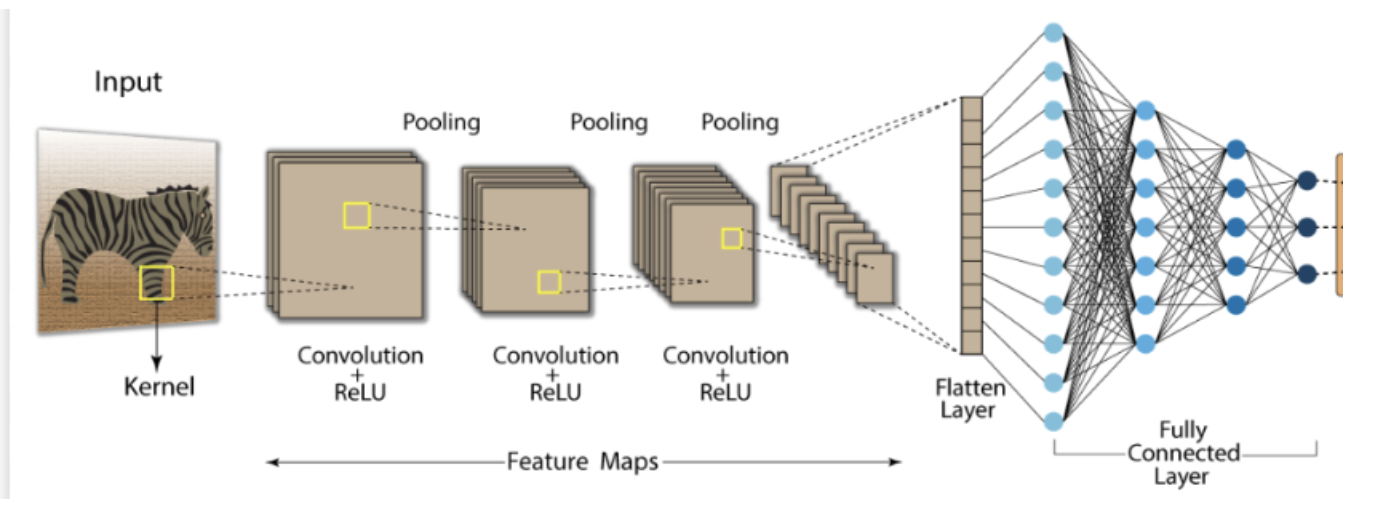

# Introduction:

The CIFAR-10 dataset contains 60,000 color images of 32 x 32 pixels in 3 channels divided into 10 classes. Each class contains 6,000 images. The training set contains 50,000 images, while the test sets provides 10,000 images. This image taken from the CIFAR repository ( https://www.cs.toronto.edu/~kriz/cifar.html ). This is a classification problem with 10 classes(muti-label classification). We can take a view on this image for more comprehension of the dataset.

**Label Encoding is as follows:**

| **Label** | **Type** |
| -: | :-: |
| 0 | airplane |
| 1 | automobile |
| 2 | bird |
| 3 | cat |
| 4 | deer |
| 5 | dog |
| 6 | frog |
| 7 | horse |
| 8 | ship |
| 9 | truck |

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import pickle
import os
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
torch.manual_seed(1) # Set manual seed
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

# Define GPU device - We will run our model on GPU
mps_device = torch.device("cuda")

# 1. Data Preparation


The idea here is to pass as much as different transformed images to our model so that our model learns complex patterns and restricts itself to overfit.

The following steps have been implemented for the same

- *Image resizing* : As the image size from source is 32X32 we apply resize function just to make sure every images passed to our process is similar in terms of size


- *Image transformation*: We apply different transformation to the image. Details mentioned below. Here one point to note is that we can randomly apply every type of transformation as this might lead to underfitting. The reason behind this is that the resolution of the images is already very low and applying some critical transfortions like centercrop, vertical flip and other might decay model performance


- *Apply normalization to image*: The mean and standard deviation is taken from different studies researchers have implemented and have them to converge faster. You can experiment with different image size and standard deviations as well


- *Apply Random Erasing*: It helps in randomly adding some noise to the image, so that the model can learn to generalize better.

**Define the image size and transformation pipeline for training and validation**

In [ ]:
IMAGE_SIZE = 32

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
# These values are mostly used by researchers as found to very useful in fast convergence


# https://pytorch.org/vision/stable/transforms.html
# We can try various transformation for good generalization of model
composed_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize the image in a 32X32 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                            contrast = 0.1,
                                                            saturation = 0.1),
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1), # Randomly adjust sharpness
                                     transforms.ToTensor(),   # Converting image to tensor
                                     transforms.Normalize(mean, std), # Normalizing with standard mean and standard deviation
                                     transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)])


composed_test = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])


**Load train and validation dataset**

In [ ]:
# Load the data and transform the dataset
train_dataset =  dsets.CIFAR10(root='./data', train=True, download=True, transform = composed_train)
validation_dataset = dsets.CIFAR10(root='./data', train=False, download=True, transform = composed_test)

# Create train and validation batch for training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

Files already downloaded and verified



Files already downloaded and verified


**Some important functions to print the images and image convertor from tensor to numpy**

In [ ]:
def show_data(img):
    try:
        plt.imshow(img[0])
    except Exception as e:
        print(e)
    print(img[0].shape, img[0].permute(1,2,0).shape)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('y = '+ str(img[1]))
    plt.show()

# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):
    #Lets
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1) # Clipping the size to print the images later
    return img

**Lets print some random datasets**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Invalid shape (3, 32, 32) for image data



torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


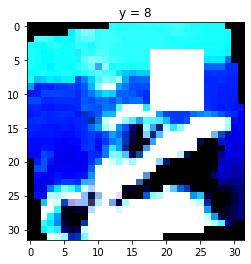

In [ ]:
show_data(train_dataset[8])

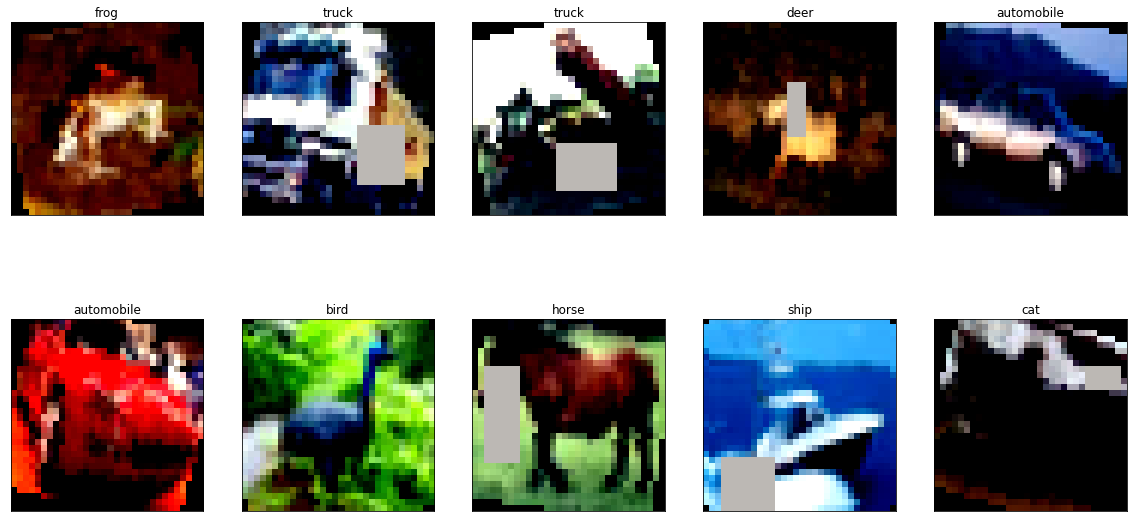

In [ ]:
# Different classes in CIPHAR 10 dataset.
classes = ('airplane',
           'automobile',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck')

# Define an iterable on the data
data_iterable = iter(train_loader) # converting our train_dataloader to iterable so that we can iter through it.
images, labels = next(data_iterable) #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(20, 10))

# Lets plot 50 images from our train_dataset
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])

    # Note: imshow cant print tensor !
    # Lets convert tensor image to numpy using im_convert function for imshow to print the image
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

## 2. Convolution Neural Network Implementation

Steps followed for the modelling process:

1) Define a rough model architecture to follow (credits to IBM for image)

2) Starting with 2 Convolution layer and 1 fully connected layer (fc)

3) Keep adding hidden layers to the above model and check of validation accuracy improves.

4) Note if we increase model layers and neurons this might lead to slower training and increase chances of overfitting. Also increase complexitu might led to getting stuck at saddle point or local minima. Hence to cater all this potential problems, experimented with momentum, dropout & He weight initialization

**i) Define common model training module**

In [ ]:
def train_model(model, train_loader, validation_loader, optimizer, n_epochs = 20):

    # Global variable
    N_test = len(validation_dataset)
    accuracy_list = []
    train_loss_list = []
    model = model.to(mps_device)
    train_cost_list = []
    val_cost_list = []

    for epoch in range(n_epochs):
        train_COST = 0
        for x,y in train_loader:
            x = x.to(mps_device)
            y = y.to(mps_device)
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
            train_COST+=loss.item()

        train_COST = train_COST/len(train_loader)
        train_cost_list.append(train_COST)
        correct = 0

        # Perform the prediction on the validation data
        val_COST = 0
        for x_test, y_test in validation_loader:
            model.eval()
            x_test = x_test.to(mps_device)
            y_test = y_test.to(mps_device)
            z = model(x_test)
            val_loss = criterion(z, y_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat==y_test).sum().item()
            val_COST+=val_loss.item()

        val_COST = val_COST/ len(validation_loader)
        val_cost_list.append(val_COST)

        accuracy = correct / N_test
        accuracy_list.append(accuracy)

        print("--> Epoch Number : {}".format(epoch + 1),
              " | Training Loss : {}".format(round(train_COST,4)),
              " | Validation Loss : {}".format(round(val_COST,4)),
              " | Validation Accuracy : {}%".format(round(accuracy * 100, 2)))

    return accuracy_list, train_cost_list, val_cost_list

**ii) CNN Model V1:**

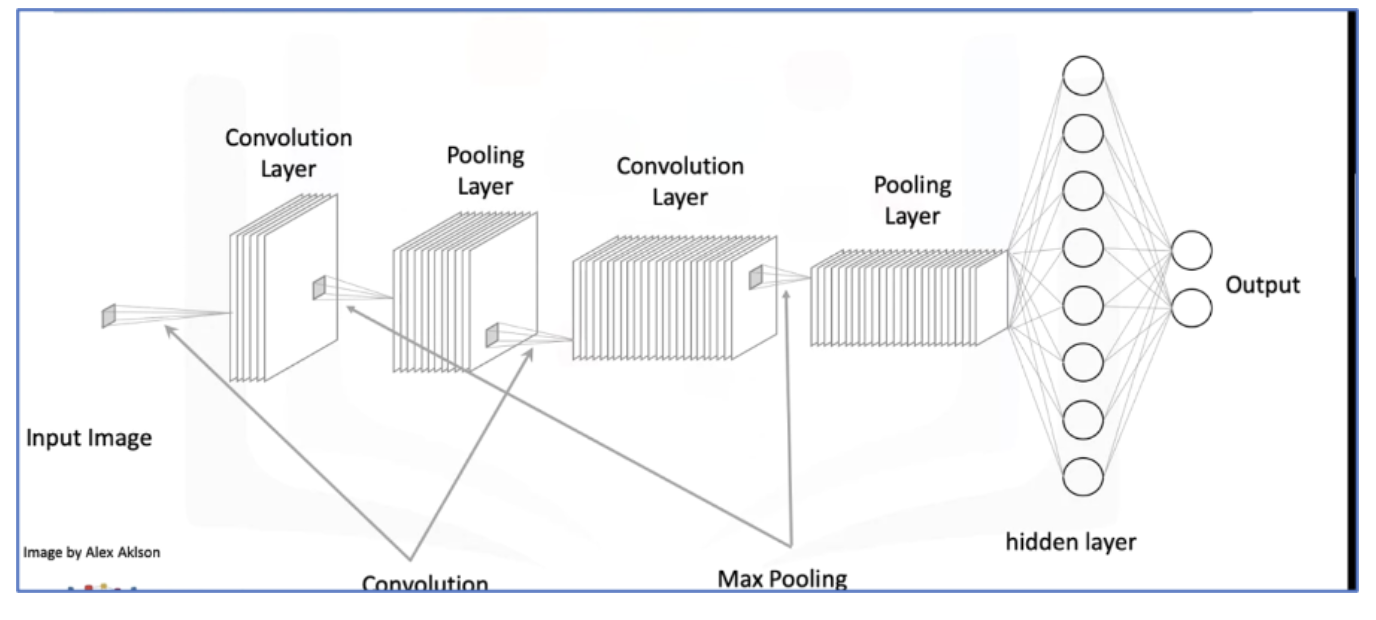

Image Credits : IBM

In [ ]:
class CNN(nn.Module):
    '''
    CNN Model V1:
    1. 2 convolution + max pool layers
    2. 1 fully connected layers
    3. Default runtime using 0 momentum and 0 dropout value
    '''

    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)


        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, number_of_classes)
        # Calculation of how we got 8*8 is mentioned in the below comment

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1) #flatten
        x = self.fc1(x)
        return(x)

This is how we get the 8x8 image size after cnn1, maxpool1, cnn2 and maxpool2:

   1. 'out_2' is a given parameter when  the cnn2 was defined, it is the output of cnn2 equal to 32

   2. 8x8 is the result of the 'image size' after cnn1, maxpool1, cnn2 and maxpool2:

2.a. Input size is 32x32

2.b. after cnn1, size per channel (total of 16 channels) is (32 + 2*2 -5)/1 + 1 = 32x32

2.c after maxpool 1, size per channel (still total of 32 channels) is (32 + 2*0 - 2)/2 + 1 (stride size is equal to kernel size of 2) = 16x16

2.c after cnn2, size per channel is (16+ 2*2 -5)/1 + 1 =16x16

2.d. after maxpool2, size per channel is (16  + 2*0 -2)/2 + 1= 8x8

**Define loss function, optimizer, dataset loader**

In [ ]:
# Define the model
model = CNN(out_1=32, out_2=64, number_of_classes = 10)

# Define model training hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Train the model
accuracy_list_normal, train_cost_list, val_cost_list = train_model(model=model,n_epochs=20,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

The above with momentum 0 gave less accurate results hence sticking back to momentum = 0.2

**iii) CNN Model V1 with momentum:**

In [ ]:
# Define the model
model_mmt = CNN(out_1=32, out_2=64, number_of_classes = 10)

# Define the model learning hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmt.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normal_mmt, train_cost_list_mmt, val_cost_list_mmt=train_model(model=model_mmt,n_epochs=20,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

||Epoch Number : 1 Loss : 1.4232107400894165 Validation Accuracy : 53.790000000000006% ||



||Epoch Number : 2 Loss : 1.2725424766540527 Validation Accuracy : 61.919999999999995% ||



||Epoch Number : 3 Loss : 1.2946546077728271 Validation Accuracy : 65.19% ||



||Epoch Number : 4 Loss : 1.1918790340423584 Validation Accuracy : 66.86999999999999% ||



||Epoch Number : 5 Loss : 1.1515467166900635 Validation Accuracy : 67.57% ||



||Epoch Number : 6 Loss : 1.0020251274108887 Validation Accuracy : 68.75% ||



||Epoch Number : 7 Loss : 1.1199876070022583 Validation Accuracy : 69.19% ||



||Epoch Number : 8 Loss : 1.0067973136901855 Validation Accuracy : 70.94% ||



||Epoch Number : 9 Loss : 1.0701792240142822 Validation Accuracy : 69.37% ||



||Epoch Number : 10 Loss : 1.0010805130004883 Validation Accuracy : 69.05% ||



||Epoch Number : 11 Loss : 1.0876988172531128 Validation Accuracy : 70.26% ||



||Epoch Number : 12 Loss : 0.9300403594970703 Validation Accuracy : 69.42% ||




In [ ]:
# Save model:
pickle.dump(model, open('./model/CNN_momentum_V1.pkl', 'wb'))

#CNN_momentum_V1 - 2 CNN Layers, Momentum = 0.2,
# model_mmt = pickle.load(open('./model/CNN_momentum_V1.pkl', 'rb'))

**iv) CNN Model V2:**

Added one more hidden layer in the Fully connected segment of the model.
Used momentum = 0.2 and dropout value = 0.5

In [ ]:
class CNN_V2(nn.Module):
    '''
    CNN Model V2:
    1. 2 convolution & max pool layers
    2. 2 fully connected layers
    3. Default runtime using 0.2 momentum and dropout value p = 0.5
    '''
    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10, p = 0):
        super(CNN_V2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)


        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, 1000) # Roughly taken seein the input and the output
        self.drop = nn.Dropout(p=p)
        self.fc2 = nn.Linear(1000, number_of_classes)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        return(x)

In [ ]:
# Define the model
model_mmtv2 = CNN_V2(out_1=32, out_2=64, number_of_classes = 10, p=0.5)

# Define model learning hyperparamters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv2.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normal, train_cost_list, val_cost_list=train_model(model=model_mmtv2,n_epochs=20,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

||Epoch Number : 1  | Loss : 1.5859053134918213  | Validation Accuracy : 52.43% ||



||Epoch Number : 2  | Loss : 1.2447062730789185  | Validation Accuracy : 60.69% ||



||Epoch Number : 3  | Loss : 1.0738451480865479  | Validation Accuracy : 64.97% ||



||Epoch Number : 4  | Loss : 1.1572234630584717  | Validation Accuracy : 67.13% ||



||Epoch Number : 5  | Loss : 1.1253089904785156  | Validation Accuracy : 68.97999999999999% ||



||Epoch Number : 6  | Loss : 0.8390576243400574  | Validation Accuracy : 71.24000000000001% ||



||Epoch Number : 7  | Loss : 0.8008708953857422  | Validation Accuracy : 72.36% ||



||Epoch Number : 8  | Loss : 0.9728328585624695  | Validation Accuracy : 72.85000000000001% ||



||Epoch Number : 9  | Loss : 0.744985044002533  | Validation Accuracy : 73.41% ||



||Epoch Number : 10  | Loss : 0.7717729210853577  | Validation Accuracy : 74.29% ||



||Epoch Number : 11  | Loss : 0.9000828266143799  | Validation Accuracy : 73.99% ||



||Epoch Number : 

*Takeaway*: The accuracy improved by some bits using momentum, dropout and additional fc layer combo hence we will keep momentum & dropouts intact for other models as well

In [ ]:
# Save model
model_mmtv2 = model_mmtv2.to(torch.device("cpu"))
pickle.dump(model_mmtv2, open('./model/CNN_momentum_V2.pkl', 'wb'))

**v) CNN Model V3 :**

Added one more hidden layer in the Fully connected segment of the model.
Used momentum = 0.2 and dropout value = 0.5

In [ ]:
class CNN_V3(nn.Module):
    '''
    CNN Model V3:
    1. 2 convolution & max pool layers
    2. 3 fully connected layers
    3. Default runtime using 0.2 momentum and dropout value p = 0.5
    '''
    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10, p = 0):
        super(CNN_V3, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)

        # Hidden layer 1
        self.fc1 = nn.Linear(out_2 * 8 * 8, 1000) # Roughly taken seein the input and the output
        self.drop = nn.Dropout(p=p)

        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)

        # Final layer
        self.fc3 = nn.Linear(1000, 10)

    # Predictiona
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        x = F.relu(self.drop(x))
        x = self.fc3(x)
        return(x)

In [ ]:
# Define the model
model_mmtv3 = CNN_V3(out_1=32, out_2=64, number_of_classes = 10, p=0.5)

# Define the model training hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv3.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normal, loss_list_normal=train_model(model=model_mmtv3,n_epochs=20,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

*Takeaway*: The accuracy improved by some perctange on further addition of the hidden layer. Lets test some more models

In [ ]:
# Save model
model_mmtv3 = model_mmtv3.to(torch.device("cpu"))
pickle.dump(model_mmtv3, open('./model/CNN_momentum_V3.pkl', 'wb'))
#CNN_mom/entum_V3 - 2 CNN Layers, 2 hidden layers, Momentum = 0.2

**vi) CNN Model V3_V2 :**

Adding one more hidden layer & one more convolution layer

In [ ]:
class CNN_V3_V2(nn.Module):

    '''
    CNN Model V3-V2:
    1. 3 convolution & max pool layers
    2. 3 fully connected layers
    3. Default runtime using 0.2 momentum and dropout value p = 0.5
    '''
    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(CNN_V3_V2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)

        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)

        # Hidden layer 1
        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000)
        # 8x8 will change to 4x4 as we added a convolution & max pool layer refer calculation comment above
        self.drop = nn.Dropout(p=p)

        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)

        # Final layer
        self.fc3 = nn.Linear(1000, 10)

    # Predictiona
    def forward(self, x):

        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        x = F.relu(self.drop(x))
        x = self.fc2(x)

        x = F.relu(self.drop(x))
        x = self.fc3(x)

        return(x)

In [ ]:
# Define model
model_mmtv4 = CNN_V3_V2(out_1=32, out_2=64, out_3 =128, number_of_classes = 10, p=0.5)

# Define the model hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv4.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normalv4, loss_list_normalv4=train_model(model=model_mmtv4, n_epochs=20, train_loader=train_loader, validation_loader=validation_loader, optimizer=optimizer)

||Epoch Number : 1  | Loss : 1.5897446870803833  | Validation Accuracy : 45.660000000000004% ||



||Epoch Number : 2  | Loss : 1.3408180475234985  | Validation Accuracy : 55.92% ||



||Epoch Number : 3  | Loss : 1.3104369640350342  | Validation Accuracy : 60.050000000000004% ||



||Epoch Number : 4  | Loss : 1.1142159700393677  | Validation Accuracy : 65.66% ||



||Epoch Number : 5  | Loss : 1.1091679334640503  | Validation Accuracy : 67.73% ||



||Epoch Number : 6  | Loss : 0.994503378868103  | Validation Accuracy : 70.50999999999999% ||



||Epoch Number : 7  | Loss : 0.955308198928833  | Validation Accuracy : 71.66% ||



||Epoch Number : 8  | Loss : 0.9774465560913086  | Validation Accuracy : 72.56% ||



||Epoch Number : 9  | Loss : 0.762923538684845  | Validation Accuracy : 73.95% ||



||Epoch Number : 10  | Loss : 0.8134365677833557  | Validation Accuracy : 75.18% ||



||Epoch Number : 11  | Loss : 0.8584408164024353  | Validation Accuracy : 75.03% ||



||Epoch Number : 

*Takeaway*: The accuracy again improved by some perctange on further addition of the FC layer and the convolution and max pool layer. Now lets see if we can converge faster with similar performance using He intialization

In [ ]:
model_mmtv4 = model_mmtv4.to(torch.device("cpu"))
pickle.dump(model_mmtv4, open('./model/CNN_momentum_V4.pkl', 'wb'))
#CNN_momentum_V4 - 3 CNN Layers, 2 hidden layers, Momentum = 0.2

**vii) CNN Model V3-V3 :**

Adding one more fully connected layer and initializing weights using He initialization

In [ ]:
class CNN_V3_V3(nn.Module):
    '''
    CNN Model V3-V2:
    1. 3 convolution & max pool layers
    2. 4 fully connected layers
    3. Default runtime using 0.2 momentum and dropout value p = 0.5
    4. Weights initialized using He weight initialization
    '''
    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(CNN_V3_V3, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)

        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)

        # Hidden layer 1
        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000)
        torch.nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.drop = nn.Dropout(p=p)

        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)
        torch.nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu') # He weight initialization

        # Hidden layer 3
        self.fc3 = nn.Linear(1000, 1000)
        torch.nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu') # He weight initialization

        # Final layer
        self.fc4 = nn.Linear(1000, 10)
        torch.nn.init.kaiming_uniform_(self.fc4.weight, nonlinearity='relu') # He weight initialization

    # Predictiona
    def forward(self, x):

        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        x = F.relu(self.drop(x))
        x = self.fc2(x)

        x = F.relu(self.drop(x))
        x = self.fc3(x)

        x = F.relu(self.drop(x))
        x = self.fc4(x)

        return(x)

In [ ]:
# Define the model
model_mmtv5 = CNN_V3_V3(out_1=32, out_2=64, out_3 =128, number_of_classes = 10, p=0.5)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv5.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normalv5, loss_list_normalv5=train_model(model=model_mmtv5, n_epochs=20, train_loader=train_loader, validation_loader=validation_loader, optimizer=optimizer)

||Epoch Number : 1  | Loss : 1.7889418601989746  | Validation Accuracy : 40.92% ||



||Epoch Number : 2  | Loss : 1.556748628616333  | Validation Accuracy : 47.18% ||



||Epoch Number : 3  | Loss : 1.4010238647460938  | Validation Accuracy : 54.50000000000001% ||



||Epoch Number : 4  | Loss : 1.37865149974823  | Validation Accuracy : 57.93000000000001% ||



||Epoch Number : 5  | Loss : 1.2805125713348389  | Validation Accuracy : 61.67% ||



||Epoch Number : 6  | Loss : 1.1632624864578247  | Validation Accuracy : 63.839999999999996% ||



||Epoch Number : 7  | Loss : 1.2272167205810547  | Validation Accuracy : 66.08000000000001% ||



||Epoch Number : 8  | Loss : 1.0671894550323486  | Validation Accuracy : 65.98% ||



||Epoch Number : 9  | Loss : 0.996748149394989  | Validation Accuracy : 67.42% ||



||Epoch Number : 10  | Loss : 1.015758752822876  | Validation Accuracy : 68.73% ||



||Epoch Number : 11  | Loss : 1.0274903774261475  | Validation Accuracy : 70.30999999999999% ||

*Takeaway*: The accuracy reduced drastically using He weight initialization. Lets drop this approach as we couldnt find global minima through this approach. Lets use traditional random weight initialization with the above architecture

In [ ]:
model_mmtv5 = model_mmtv5.to(torch.device("cpu"))
pickle.dump(model_mmtv5, open('./model/CNN_momentum_V5.pkl', 'wb'))
#CNN_momentum_V5 - 3 CNN Layers, 2 hidden layers, Momentum = 0.2, He Weight initialization

 **viii) CNN Model V3-V4**

USed similar architecture as CNN_V3_V3. The only difference is additon of more more fc layer and removal of He weight initialization.


**Extra additions to model apart from additional convolution layer**
1. Lets add dropout to convolution layers with p=0.2 as high value might lead to underfit as these are the initial layers from which the model extract useful features from the image.
2. Added Batch normalization as this will help us to converge faster

In [ ]:
class CNN_V3_V4(nn.Module):
    """
    Adding one more hidden layer & dropout value & one more convolution layer
    Total 3 hidden layers, 3 convolution layer & Batch Normalization
    """
    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(CNN_V3_V4, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.drop_conv = nn.Dropout(p=0.2)

        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        self.conv3_bn = nn.BatchNorm2d(out_3)

        # Hidden layer 1
        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000)
        self.drop = nn.Dropout(p=p)
        self.fc1_bn = nn.BatchNorm1d(1000)

        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)
        self.fc2_bn = nn.BatchNorm1d(1000)

        # Hidden layer 3
        self.fc3 = nn.Linear(1000, 1000)
        self.fc3_bn = nn.BatchNorm1d(1000)

        # Hidden layer 4
        self.fc4 = nn.Linear(1000, 1000)
        self.fc4_bn = nn.BatchNorm1d(1000)

        # Final layer
        self.fc5 = nn.Linear(1000, 10)
        self.fc5_bn = nn.BatchNorm1d(10)

    # Predictiona
    def forward(self, x):

        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = self.maxpool1(x)
        x = self.drop_conv(x)

        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.drop_conv(x)

        x = self.cnn3(x)
        x = self.conv3_bn(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = self.drop_conv(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc1_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc2(x)
        x = self.fc2_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc3(x)
        x = self.fc3_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc4(x)
        x = self.fc4_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc5(x)
        x = self.fc5_bn(x)

        return(x)

In [ ]:
model_mmtv5 = CNN_V3_V4(out_1=32, out_2=64, out_3 =128, number_of_classes = 10, p=0.5)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv5.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normalv5, train_cost_listv5, val_cost_listv5=train_model(model=model_mmtv5, n_epochs=200, train_loader=train_loader, validation_loader=validation_loader, optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.7227  | Validation Loss : 1.358  | Validation Accuracy : 50.49%



--> Epoch Number : 2  | Training Loss : 1.4559  | Validation Loss : 1.2134  | Validation Accuracy : 56.95%



--> Epoch Number : 3  | Training Loss : 1.3364  | Validation Loss : 1.0479  | Validation Accuracy : 62.88%



--> Epoch Number : 4  | Training Loss : 1.2545  | Validation Loss : 0.9479  | Validation Accuracy : 66.37%



--> Epoch Number : 5  | Training Loss : 1.1937  | Validation Loss : 0.903  | Validation Accuracy : 68.37%



--> Epoch Number : 6  | Training Loss : 1.1447  | Validation Loss : 0.8512  | Validation Accuracy : 70.29%



--> Epoch Number : 7  | Training Loss : 1.1031  | Validation Loss : 0.8372  | Validation Accuracy : 70.38%



--> Epoch Number : 8  | Training Loss : 1.0719  | Validation Loss : 0.7967  | Validation Accuracy : 72.36%



--> Epoch Number : 9  | Training Loss : 1.0432  | Validation Loss : 0.7783  | Validation Accuracy : 72.92%



--> Epoch Nu

In [ ]:
# Save the model
model_mmtv5 = model_mmtv5.to(torch.device("cpu"))
pickle.dump(model_mmtv5, open('./model/CNN_momentum_V8_12_01_23.pkl', 'wb'))
#CNN_momentum_V5 - 3 CNN Layers, 3 hidden layers, Momentum = 0.2

# model_mmtv5 = pd.read_pickle('./model/CNN_momentum_V7.pkl')
# model_mmtv5 = model_mmtv5.to(mps_device)

# 3. Model Performance Report & Error Analysis

**i) Printing model training loss vs accuracy:**

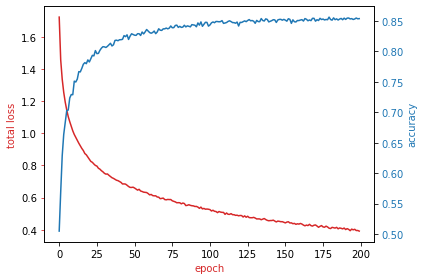

In [ ]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(train_cost_listv5,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot( accuracy_list_normalv5, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

**Takeaway**

As we can see that there is no sort of anomolous behavior in model traning and model converges to minima smoothly

**ii) Printing training and validation loss:**

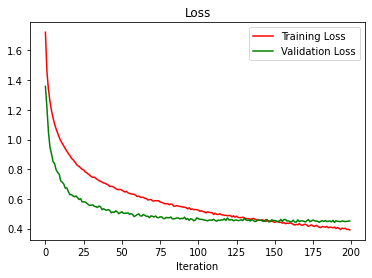

In [ ]:
plt.plot(train_cost_listv5, 'r', label='Training Loss')
plt.plot(val_cost_listv5,  'g',  label='Validation Loss')
plt.xlabel("Iteration")
plt.title("Loss")
plt.legend()

**Takeaways :**

We can see that the training loss and validation loss are close to each other. This gives a sense that we did a decent job in **avoiding our model to overfit.**

**iii) Error Analysis: Printing Confusion Matrix & Classification Report :**

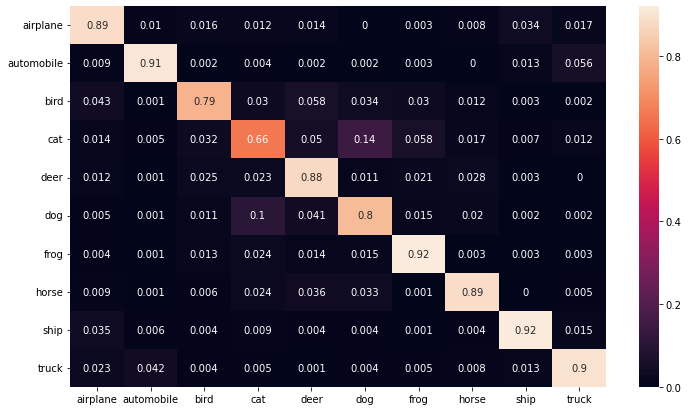

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):

    #print('iter val', i)
    x = x.to(mps_device)
    y = y.to(mps_device)
    z = model_mmtv5(x)
    _, yhat = torch.max(z, 1)
    pred = yhat.data.cpu().numpy()
    y_pred.extend(pred) # Save Prediction

    labels = y.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support







           0       0.85      0.89      0.87      1000



           1       0.93      0.91      0.92      1000



           2       0.87      0.79      0.83      1000



           3       0.74      0.66      0.70      1000



           4       0.80      0.88      0.84      1000



           5       0.76      0.80      0.78      1000



           6       0.87      0.92      0.89      1000



           7       0.90      0.89      0.89      1000



           8       0.92      0.92      0.92      1000



           9       0.89      0.90      0.89      1000







    accuracy                           0.85     10000



   macro avg       0.85      0.85      0.85     10000



weighted avg       0.85      0.85      0.85     10000






Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Invalid shape (3, 32, 32) for image data



torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


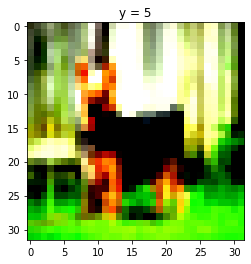

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yhat:  tensor([4], device='mps:0')



Invalid shape (3, 32, 32) for image data



torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


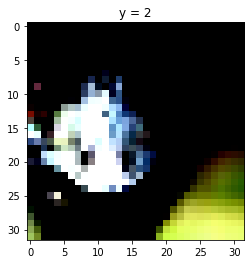

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yhat:  tensor([1], device='mps:0')



Invalid shape (3, 32, 32) for image data



torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


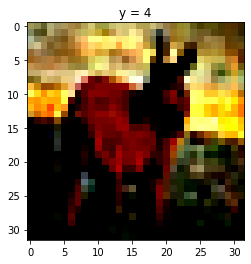

yhat:  tensor([7], device='mps:0')


In [ ]:
# Plot the mis-classified samples
count = 0
i = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    #print('iter val', i)
    x = x.to(mps_device)
    y = y.to(mps_device)
    z = model_mmtv5(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data(validation_dataset[i])
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 3:
        break
    i+=1

**Takeaway**

1) Model is not able to perform well in predicting bird, cats, dogs as compared to other class.

2) Overall model accuracy is decent. If we are able to get more data for cats and dogs we can improve our model performance

3) As we can see in the above image model gets confused in predicting airplane an bird, which is fair enough as the underlying matrix might resemble very close to each other. Hence if we can get more training data or we can specifically add more oversampling of data for model to learn better, there is chance to further boost the accuracy.

**iv) Printing how out model performs on the first 20 images:**

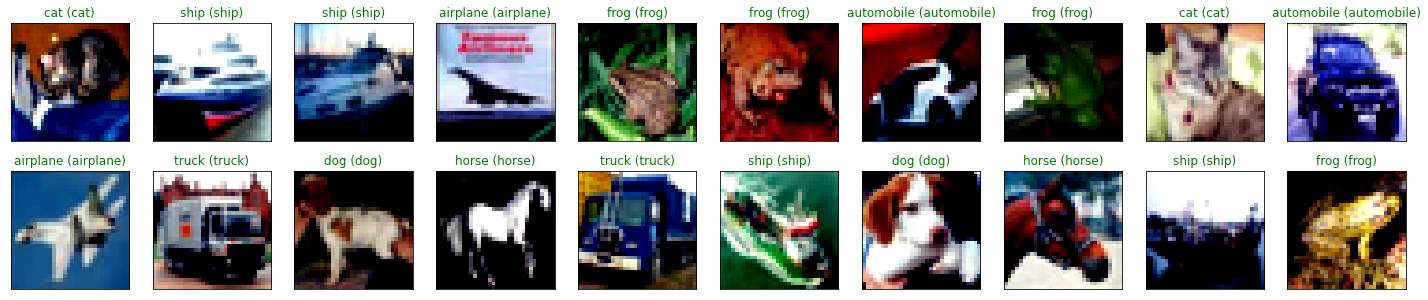

In [ ]:
data_iterable = iter(validation_loader)
images, labels = next(data_iterable)
images = images.to(mps_device)
labels = labels.to(mps_device)
output = model_mmtv5(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 5))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

# 4. Performance on Hold-Out Set

**Randomly test our model performance on random image taken from internet and see how our model performs on totally unseen data**

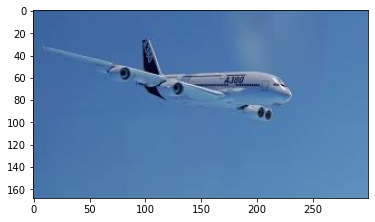

In [ ]:
# Ex1

url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRsa3ISspmdRq4nDC9M6pfoNh1TvukFHBzGuA&usqp=CAU'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

# Image cleared to reduce size of ipynb file

Prediction by Model: airplane


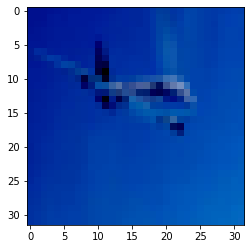

In [ ]:
# Convert holdout image to testing format
img = composed_test(img)
plt.imshow(im_convert(img))

image = img.to(mps_device).unsqueeze(0)
output = model_mmtv5(image)
_, pred = torch.max(output, 1)
print("Prediction by Model:", (classes[pred.item()]))

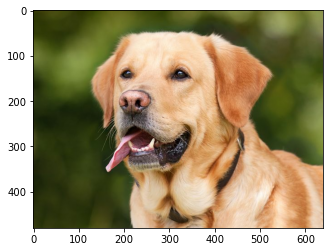

In [ ]:
# Ex2

url = 'https://cdn.pixabay.com/photo/2016/02/19/15/46/labrador-retriever-1210559__480.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

# Image cleared to reduce size of ipynb file

Prediction by Model: dog


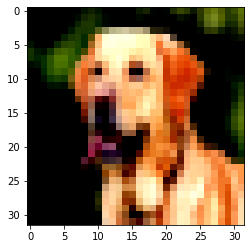

In [ ]:
# Convert holdout image to testing format
img = composed_test(img)
plt.imshow(im_convert(img))
image = img.to(mps_device).unsqueeze(0)
output = model_mmtv5(image)
_, pred = torch.max(output, 1)
print("Prediction by Model:", (classes[pred.item()]))

# 5. Prediction on Test

In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Define the path where images are stored by yourself.
        # Remember, the first image is ./train/1.png
        img_path = self.img_dir + '/' + str(self.img_labels.iloc[idx, 0]) +'.png'

        # Read image. Recall how you converted an image to numpy array in the previous step.
        image = np.asarray(Image.open(img_path).convert('RGB'))

        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
# Creating transform pipeline for test data
composed_test_check = transforms.Compose([transforms.ToPILImage(),
                                          transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean, std)])

SUBMISSION = os.path.join(os.getcwd(),"data/sampleSubmission.csv")
test_dataset = TestImageDataset(annotations_file=SUBMISSION, img_dir='./data/test', transform=composed_test_check)
test_loader = DataLoader(dataset=test_dataset, batch_size=500, shuffle=False)

# Load the submission file
submit_df = pd.read_csv(SUBMISSION)

# Define an encoder
label_encoder = preprocessing.LabelEncoder()
# Fit the encoder
label_encoder.fit_transform(list(classes))

# Iteratively predict the target and update the submission file
model_mmtv5 = model_mmtv5.to(mps_device)
i = 0
y_test_pred_list = []
for X_test, _ in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000):

    X_test = X_test.to(mps_device) # Move X_train to the GPU
    model_mmtv5.eval()

    _, y_test_pred = torch.max(model_mmtv5(X_test), 1) # Pick the most probable label

    # Move the predicted values to CPU.
    y_test_pred = y_test_pred.cpu()

    # As submission expects actual category names such as cat, the predicted values have to be transformed.
    y_test_pred = label_encoder.inverse_transform(y_test_pred)
    y_test_pred_list.extend(y_test_pred)

# Add labels to submission file
submit_df['label'] = y_test_pred_list

In [ ]:
# Save submission
submit_df.to_csv('submission_CNNV3V4_01_2023_V2.csv', index = False)

![image.png](attachment:image.png)

Reached greater than 85% accuracy on private test data. Due to late submission it is not accepting it to be posted on private leaderboard.

Till now we tried different customer architectures by manually experiementing around different models. We are avle to cross 85% accuracy mark. Can we do even better?

The answer is yes we can: Resnet comes to rescue. Lets read about it below.

# Resnet -34 The Deep Killer

So what is Resnet:

Resnet34 is a state-of-the-art image classification model, structured as a 34 layer convolutional neural network and defined in "Deep Residual Learning for Image Recognition". Restnet34 is pre-trained on the ImageNet dataset which contains 100,000+ images across 200 different classes. This gives a good starting point for weights initialization for our CIFAR dataset.

Note this is a pre-trained model but I have manually attempted few architectures in the above code to build a model with decent accuracy.

Below code is just a overview given competition spirit and accuracy war people hold ;) Kidding its just for learning.

You can find more about Restnet-34 here :

https://roboflow.com/model/resnet-34#:~:text=What%20is%20Resnet34%3F,images%20across%20200%20different%20classes.
        

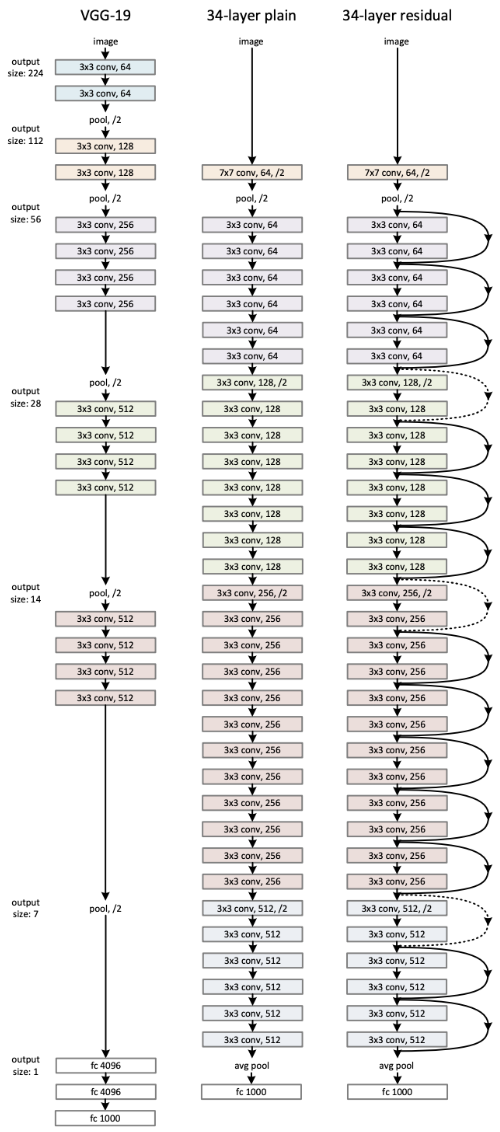

**Define Image Size & similarly get the training and validation data**

In [ ]:
IMAGE_SIZE = 224 # We need to resize the images given resnet takes input of image size >= 224

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
# These values are mostly used by researchers as found to very useful in fast convergence


# https://pytorch.org/vision/stable/transforms.html
# We can try various transformation for good generalization of model
composed_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize the image in a 32X32 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                            contrast = 0.1,
                                                            saturation = 0.1),
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1), # Randomly adjust sharpness
                                     transforms.ToTensor(),   # Converting image to tensor
                                     transforms.Normalize(mean, std), # Normalizing with standard mean and standard deviation
                                     transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)])


composed_test = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])


# Load the data and transform the dataset
train_dataset =  dsets.CIFAR10(root='./data',
                               train=True,
                               download=True,
                               transform = composed_train)
validation_dataset = dsets.CIFAR10(root='./data',
                                   train=False,
                                   download=True,
                                   transform = composed_test)

# Create train and validation batch for training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

In [ ]:
def resnet_34():
    # Define the resnet model
    resnet = torchvision.models.resnet34(pretrained=True)

    # Update the fully connected layer of resnet with our current target of 10 desired outputs
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 10)

    # Initialize with xavier uniform
    torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet

model_mmtv6 = resnet_34()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv5.parameters(),
                            lr = learning_rate,
                            momentum = 0.2)

# Define the Scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min')

# Train the model
accuracy_list_normalv5, train_cost_listv5, val_cost_listv5=train_model(model=model_mmtv5,
                                                                       n_epochs=25,
                                                                       train_loader=train_loader,
                                                                       validation_loader=validation_loader,
                                                                       optimizer=optimizer,
                                                                       scheduler = scheduler)

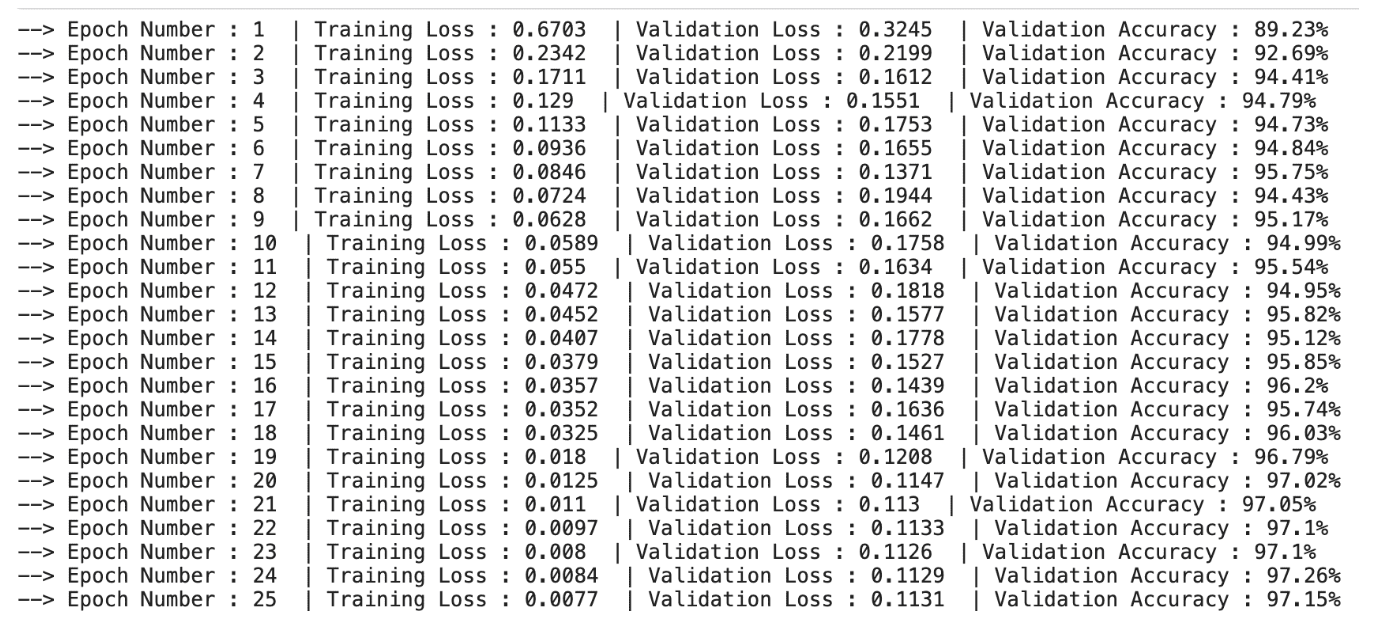

Final Result: **97.15%**

Isn't it dope?!